In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
import p5lib
import pickle
import os.path

%matplotlib inline

In [141]:
pickle_file = 'reduced_data.pickle'
if os.path.isfile(pickle_file):
    data = pickle.load(open(pickle_file, "rb"))
else:
    data = pd.read_csv('MERGED2013_PP.csv')
    # print data.shape
    data = p5lib.preprocess_data(data)
    pickle.dump(data, open(pickle_file, "wb"))

print data.shape

(6007, 45)


In [142]:
X = data[['CONTROL', 'DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'PAR_ED_PCT_1STGEN', 
          'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 'UGDS', 
          'WDRAW_DEBT_MDN', 'L4_COLLEGE', 'NPT4', 'NUM4', 
          'PFTFTUG1_EF', 'PFTFAC',
          'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 'AVGFACSAL', 'COSTT4_A',
          'CCSIZSET', 'CCUGPROF', 'CCBASIC', # carnegie classification data (which is not complete)
          'C150', 'RET_FT']]

# remove noise, this bumps up the r2 score pretty nicely
X = X[~((X.RET_FT == 0) & (X.C150 > 0.5))]
X = X[~((X.C150 == 0) & (X.RET_FT > 0.5))]
X = X[~((X.C150 == 1) & (X.RET_FT < 0.5))]
X = X[~((X.RET_FT == 1) & (X.C150 < 0.5))]

y = X[['C150', 'RET_FT']]
X = X.drop('C150', 1)
X = X.drop('RET_FT', 1)
print X.shape
print y.shape
print len(X.dropna())


(5930, 28)
(5930, 2)
1145


In [143]:
fill_cols_with_mean = ['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'WDRAW_DEBT_MDN',
                       'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 
                       'UG25abv', 'NPT4', 'NUM4', 'PFTFTUG1_EF', 'PFTFAC', 'SAT_AVG_ALL', 'ACTCMMID', 'ADM_RATE_ALL', 
                       'AVGFACSAL', 'COSTT4_A']

for col in fill_cols_with_mean:
    if col in X:
        X[col] = X[col].fillna(X[col].mean())

In [144]:
p5lib.print_num_data_for_each_features(X)

Number of available data for each feature (not counting the NaN values)
CONTROL             Control (public/private)                      5930
DEBT_MDN            Median debt                                   5930
DEP_INC_AVG         Avg income dependent stu                      5930
GRAD_DEBT_MDN       Median debt complete                          5930
IND_INC_AVG         Avg income independent stu                    5930
INEXPFTE            Expense per FTE student                       5930
PAR_ED_PCT_1STGEN   % 1st gen students                            5930
PAR_ED_PCT_HS       % parent education high school                5930
PAR_ED_PCT_MS       % parent education middle school              5930
PAR_ED_PCT_PS       % parent education post secondary             5930
PCTFLOAN            % Fed student loan                            5930
PCTPELL             % Pell Grant receiver                         5930
UG25abv             % undergrad > 25 yr                           5930
UGDS 

Note that the Carnegie classification features do not contain complete data for all 5930 rows

In [145]:
from sklearn import preprocessing

# take features of type cost/money, and percentage (between 0 and 1) and preprocess with standard scaler
# and then use these preprocessed features for PCA
tmpX = X[['DEBT_MDN', 'DEP_INC_AVG', 'GRAD_DEBT_MDN', 'IND_INC_AVG', 'INEXPFTE', 'UGDS', 'WDRAW_DEBT_MDN', 'NPT4', 
          'NUM4', 'SAT_AVG_ALL', 'ACTCMMID', 'AVGFACSAL', 'COSTT4_A',
          'PAR_ED_PCT_1STGEN', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_MS', 'PAR_ED_PCT_PS', 'PCTFLOAN', 'PCTPELL', 'UG25abv', 
          'PFTFTUG1_EF', 'PFTFAC', 'ADM_RATE_ALL'
         ]]

scaler = preprocessing.StandardScaler()

scaledX = scaler.fit_transform(tmpX)
print scaledX.shape


(5930, 23)


In [146]:
from sklearn.decomposition import PCA

pca = PCA(n_components=scaledX.shape[1])
pca.fit(scaledX)

print pca.explained_variance_ratio_

[  3.27847019e-01   1.23902660e-01   9.73258255e-02   6.85293297e-02
   5.77802450e-02   4.73264511e-02   4.20430022e-02   3.91336823e-02
   3.44479046e-02   2.75580133e-02   2.50217155e-02   2.21752119e-02
   2.19309148e-02   1.60399102e-02   1.16046323e-02   9.16058349e-03
   7.49696855e-03   7.33037616e-03   4.91219481e-03   4.57979241e-03
   2.98661079e-03   5.45633907e-04   3.21322779e-04]


In [147]:
pca = PCA(n_components=15)
pca.fit(scaledX)
reducedX = pca.transform(scaledX)

# reducedX is the chosen top PCA components
print reducedX.shape

(5930, 15)


In [148]:
# add the categorical features
# only CONTROL and L4_COLLEGE because the carnegie classification data is not complete

tmp1X = np.array(pd.get_dummies(X['CONTROL']))
tmp2X = X['L4_COLLEGE'].astype(int)
tmp2X = np.reshape(tmp2X, (len(tmp2X), 1)) 

tmp3X = np.array(pd.get_dummies(X['CCSIZSET']))
tmp4X = np.array(pd.get_dummies(X['CCUGPROF']))
tmp5X = np.array(pd.get_dummies(X['CCBASIC']))

print reducedX.shape
print tmp1X.shape, tmp2X.shape, tmp3X.shape, tmp4X.shape, tmp5X.shape

finalX = np.concatenate((reducedX, tmp1X, tmp2X, tmp3X, tmp4X, tmp5X), axis=1)

print finalX.shape

(5930, 15)
(5930, 3) (5930, 1) (5930, 17) (5930, 14) (5930, 33)
(5930, 83)


In [149]:
from sklearn import cross_validation as cv

pickle_file = 'm5-split_data.pickle'

os.remove(pickle_file) # clear cache (delete pickle)
if os.path.isfile(pickle_file):
    print "loading split_data from pickle"
    split_data = pickle.load(open(pickle_file, "rb"))
    X_train, X_test, y_train, y_test = split_data['X_train'], split_data['X_test'], split_data['y_train'], split_data['y_test']
else:
    y = np.array(y)
    X_train, X_test, y_train, y_test = cv.train_test_split(finalX, y, train_size=0.8)
    split_data = {
        'X_train': X_train,
        'X_test':  X_test,
        'y_train': y_train,
        'y_test':  y_test,        
    }
    pickle.dump(split_data, open(pickle_file, "wb"))

print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

# Check if the train / test has similar distribution
print pd.DataFrame(data={'y_train c150': pd.Series(y_train[:,0]).describe(),
                         'y_test c150': pd.Series(y_test[:,0]).describe(),
                        })
print pd.DataFrame(data={'y_train ret': pd.Series(y_train[:,1]).describe(),
                         'y_test ret': pd.Series(y_test[:,1]).describe(),
                        })

(4744, 83)
(1186, 83)
(4744, 2)
(1186, 2)
       y_test c150  y_train c150
count  1186.000000   4744.000000
mean      0.528239      0.528437
std       0.236568      0.236610
min       0.019204      0.000000
25%       0.339789      0.337298
50%       0.556976      0.552201
75%       0.714296      0.720347
max       1.000000      1.000000
        y_test ret  y_train ret
count  1186.000000  4744.000000
mean      0.691149     0.691744
std       0.176017     0.173309
min       0.000000     0.000000
25%       0.588525     0.586925
50%       0.712550     0.704500
75%       0.810625     0.815500
max       1.000000     1.000000


In [150]:
DT_reg1, DT_reg2, DT_c150_19_r2, DT_ret_19_r2 = p5lib.build_DecisionTree_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.63149567142
R2 score on test  data: 0.538536519189
--- Retention ---
best params: {'max_depth': 4}
R2 score on train data: 0.281339217298
R2 score on test  data: 0.233857510785


In [151]:
DT_reg1, DT_reg2, DT_c150_r2, DT_ret_r2 = p5lib.build_DecisionTree_model(X_train, X_test, y_train, y_test)

--- Completion ---
best params: {'max_depth': 6}
R2 score on train data: 0.640495550561
R2 score on test  data: 0.569583497033
--- Retention ---
best params: {'max_depth': 4}
R2 score on train data: 0.281370389996
R2 score on test  data: 0.234117231818


In [152]:
SVR_reg1, SVR_reg2, SVR_c150_15_r2, SVR_ret_15_r2 = p5lib.build_SVR_model(X_train[:,:15], X_test[:,:15], y_train, y_test)

--- Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.727198944355
R2 score on test  data: 0.66865226909
--- Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.469006288269
R2 score on test  data: 0.360343296061


In [153]:
SVR_reg1, SVR_reg2, SVR_c150_19_r2, SVR_ret_19_r2 = p5lib.build_SVR_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.738945682645
R2 score on test  data: 0.676152774879
--- Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.481591077317
R2 score on test  data: 0.367603656846


In [154]:
SVR_reg1, SVR_reg2, SVR_c150_r2, SVR_ret_r2 = p5lib.build_SVR_model(X_train, X_test, y_train, y_test)

--- Completion ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.756529833995
R2 score on test  data: 0.68325174383
--- Retention ---
best params: {'epsilon': 0.10000000000000001, 'C': 0.10000000000000001, 'gamma': 0.10000000000000001}
R2 score on train data: 0.499324660417
R2 score on test  data: 0.366951166063


In [155]:
KNN_reg1, KNN_reg2, KNN_c150_19_r2, KNN_ret_19_r2 = p5lib.build_KNN_model(X_train[:,:19], X_test[:,:19], y_train, y_test)

--- Completion ---
best params: {'n_neighbors': 10}
R2 score on train data: 0.737117279216
R2 score on test  data: 0.6898379701
--- Retention ---
best params: {'n_neighbors': 18}
R2 score on train data: 0.434588443803
R2 score on test  data: 0.361080588045


In [156]:
KNN_reg1, KNN_reg2, KNN_c150_r2, KNN_ret_r2 = p5lib.build_KNN_model(X_train, X_test, y_train, y_test)

--- Completion ---
best params: {'n_neighbors': 12}
R2 score on train data: 0.728809566794
R2 score on test  data: 0.694812493519
--- Retention ---
best params: {'n_neighbors': 19}
R2 score on train data: 0.429708341593
R2 score on test  data: 0.364439812648


In [157]:
RForest_reg1, RForest_reg2, RF_c150_19_r2, RF_ret_19_r2 = p5lib.build_RandomForest_model(X_train[:,:19], X_test[:,:19], y_train, y_test, n_estimators=50)

--- Completion ---
R2 score on train data: 0.950117833812
R2 score on test  data: 0.672051155735
--- Retention ---
R2 score on train data: 0.905663729163
R2 score on test  data: 0.358204657272


In [158]:
RForest_reg1, RForest_reg2, RF_c150_r2, RF_ret_r2 = p5lib.build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=50)

--- Completion ---
R2 score on train data: 0.95263711437
R2 score on test  data: 0.687682488507
--- Retention ---
R2 score on train data: 0.907550776078
R2 score on test  data: 0.366740789911


In [159]:
RForest_reg1, RForest_reg2, RF_c150_best_r2, RF_ret_best_r2 = p5lib.build_RandomForest_model(X_train, X_test, y_train, y_test, n_estimators=400)

--- Completion ---
R2 score on train data: 0.955928731626
R2 score on test  data: 0.694036242709
--- Retention ---
R2 score on train data: 0.914369979991
R2 score on test  data: 0.376754414338


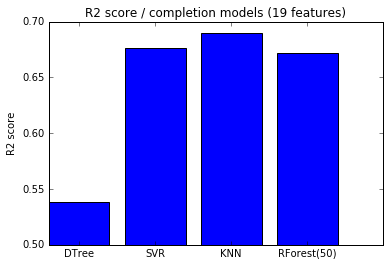

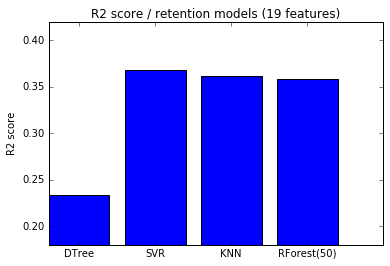

In [160]:
c150_r2 = [DT_c150_19_r2, SVR_c150_19_r2, KNN_c150_19_r2, RF_c150_19_r2]
ret_r2 = [DT_ret_19_r2, SVR_ret_19_r2, KNN_ret_19_r2, RF_ret_19_r2]

plt.title('R2 score / completion models (19 features)')
ax = plt.subplot(111)
ax.set_ylim([0.5, 0.7])
ax.bar(np.array(range(4)), c150_r2)
plt.ylabel('R2 score')
plt.xticks(np.array(range(5))+ 0.4, ['DTree', 'SVR', 'KNN', 'RForest(50)'])
plt.show()

plt.title('R2 score / retention models (19 features)')
ax = plt.subplot(111)
ax.set_ylim([0.18, 0.42])
ax.bar(np.array(range(4)), ret_r2)
plt.ylabel('R2 score')
plt.xticks(np.array(range(5))+ 0.4, ['DTree', 'SVR', 'KNN', 'RForest(50)'])
plt.show()



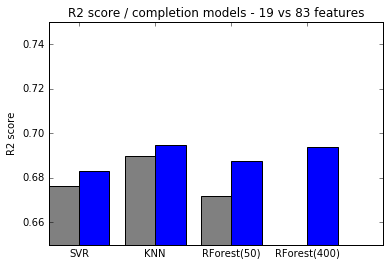

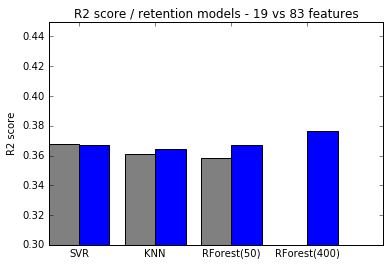

In [161]:
# compare the r2 score of the model with 19 and 83 features 
c150_r2 = [SVR_c150_r2, KNN_c150_r2, RF_c150_r2, RF_c150_best_r2]
ret_r2  = [SVR_ret_r2, KNN_ret_r2, RF_ret_r2, RF_ret_best_r2]

c150_19_r2 = [SVR_c150_19_r2, KNN_c150_19_r2, RF_c150_19_r2, 0]
ret_19_r2  = [SVR_ret_19_r2, KNN_ret_19_r2, RF_ret_19_r2, 0]


plt.title('R2 score / completion models - 19 vs 83 features')
ax = plt.subplot(111)
ax.set_ylim([0.65, 0.75])
ax.bar(np.array(range(4)), c150_19_r2, width=0.4, color='grey')
ax.bar(np.array(range(4))+0.4, c150_r2, width=0.4, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(5))+ 0.4, ['SVR', 'KNN', 'RForest(50)', 'RForest(400)'])
plt.show()

plt.title('R2 score / retention models - 19 vs 83 features')
ax = plt.subplot(111)
ax.set_ylim([0.3, 0.45])
ax.bar(np.array(range(4)), ret_19_r2, width=0.4, color='grey')
ax.bar(np.array(range(4))+0.4, ret_r2, width=0.4, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(5))+ 0.4, ['SVR', 'KNN', 'RForest(50)', 'RForest(400)'])
plt.show()


In [172]:
from sklearn.ensemble import RandomForestRegressor

# convert 1 dimensional N array into 2 dimensional Nx1
def reshape_y(y):
    return y.reshape((len(y), 1))

# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = p5lib.split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    print "--- Completion ---"
    p5lib.print_r2score(reg1, X_train, y1_train)
    r2score_reg1 = p5lib.print_r2score(reg1, X_test, y1_test, test=True)

    print "--- Retention ---"
    p5lib.print_r2score(reg2, X_train1, y2_train)
    y1_test_predicted = reg1.predict(X_test)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2score_reg2 = p5lib.print_r2score(reg2, X_test1, y2_test, test=True)

    return (reg1, reg2, r2score_reg1, r2score_reg2)

RForest_reg1, RForest_reg2, RF_c150_nested_r2, RF_ret_nested_r2 = \
    build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=400)


--- Completion ---
R2 score on train data: 0.955916401417
R2 score on test  data: 0.694228778602
--- Retention ---
R2 score on train data: 0.925034200982
R2 score on test  data: 0.394993519087


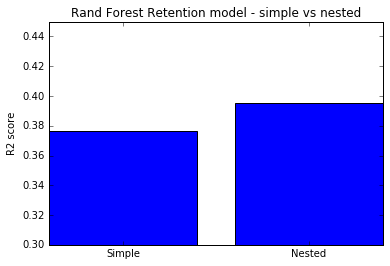

In [175]:
# Comparison of r2 score between simple vs nested model (using RandomForest with 400 estimators) 
ret_r2  = [RF_ret_best_r2, RF_ret_nested_r2]

plt.title('Rand Forest Retention model - simple vs nested')
ax = plt.subplot(111)
ax.set_ylim([0.30, 0.45])
ax.bar(np.array(range(2)), ret_r2, width=0.8, color='b')

plt.ylabel('R2 score')
plt.xticks(np.array(range(2)) + 0.4, ['Simple', 'Nested'])
plt.show()


In [ ]:
# build the model for Retention (y2) using the Completion data (y1)
# So the Retention model uses the prediction result from the Completion model
# Because we feed the prediction from completion model to the retention model, let's call this nested model
def build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=50):
    y1_train, y1_test, y2_train, y2_test = p5lib.split_y(y_train, y_test)

    reg1 = RandomForestRegressor(n_estimators=n_estimators)
    reg1.fit(X_train, y1_train)

    reg2 = RandomForestRegressor(n_estimators=n_estimators)
    
    X_train1 = np.concatenate((X_train, reshape_y(y1_train)), axis=1)
    reg2.fit(X_train1, y2_train)

    print "--- Completion ---"
    p5lib.print_r2score(reg1, X_train, y1_train)
    r2score_reg1 = p5lib.print_r2score(reg1, X_test, y1_test, test=True)

    print "--- Retention ---"
    p5lib.print_r2score(reg2, X_train1, y2_train)
    y1_test_predicted = reg1.predict(X_test)
    X_test1 = np.concatenate((X_test, reshape_y(y1_test_predicted)), axis=1)
    r2score_reg2 = p5lib.print_r2score(reg2, X_test1, y2_test, test=True)

    return (reg1, reg2, r2score_reg1, r2score_reg2)

RForest_reg1, RForest_reg2, RF_c150_nested_r2, RF_ret_nested_r2 = \
    build_RandomForest_model_nested(X_train, X_test, y_train, y_test, n_estimators=400)


In [216]:
def final_model_predict(X):
    y1_predicted = RForest_reg1.predict(X)
    X1 = np.concatenate((X, reshape_y(y1_predicted)), axis=1)
    y2_predicted = RForest_reg2.predict(X1)
    return y1_predicted, y2_predicted

# TODO: figure out why this is very slow
# delta_y1, delta_y2 = [], []
# for i, row in enumerate(X_train):
#     X_nearby = X_train[i:i+1,:].copy()
#     for i, a in enumerate(X_nearby[0]):
#         if i < 15:
#             X_nearby[0][i] += 0.1 
 
#     y1p, y2p = final_model_predict(X_train[i:i+1,:])
#     y1pn, y2pn = final_model_predict(X_nearby)
#     delta_y1.append(abs(y1pn[0] - y1p[0]))
#     delta_y2.append(abs(y2pn[0] - y2p[0]))



In [211]:
print pd.Series(delta_y1).describe() 
print pd.Series(delta_y2).describe() 

count    4744.000000
mean        0.354136
std         0.194078
min         0.000079
25%         0.199945
50%         0.394622
75%         0.514741
max         0.782999
dtype: float64
count    4744.000000
mean        0.142502
std         0.090993
min         0.000022
25%         0.066780
50%         0.138799
75%         0.207266
max         0.418311
dtype: float64


In [215]:
print pd.Series(y_train[:,0]).describe()
print pd.Series(y_train[:,1]).describe()
print pd.Series(y_test[:,0]).describe()
print pd.Series(y_test[:,1]).describe()

count    4744.000000
mean        0.528437
std         0.236610
min         0.000000
25%         0.337298
50%         0.552201
75%         0.720347
max         1.000000
dtype: float64
count    4744.000000
mean        0.691744
std         0.173309
min         0.000000
25%         0.586925
50%         0.704500
75%         0.815500
max         1.000000
dtype: float64
count    1186.000000
mean        0.528239
std         0.236568
min         0.019204
25%         0.339789
50%         0.556976
75%         0.714296
max         1.000000
dtype: float64
count    1186.000000
mean        0.691149
std         0.176017
min         0.000000
25%         0.588525
50%         0.712550
75%         0.810625
max         1.000000
dtype: float64


In [219]:
y1p, y2p = final_model_predict(X_train)
print pd.Series(y1p).describe()
print pd.Series(y2p).describe()
y1p, y2p = final_model_predict(X_test)
print pd.Series(y1p).describe()
print pd.Series(y2p).describe()

count    4744.000000
mean        0.528218
std         0.211213
min         0.073478
25%         0.358947
50%         0.558696
75%         0.699823
max         0.960598
dtype: float64
count    4744.000000
mean        0.691651
std         0.127566
min         0.129128
25%         0.603376
50%         0.700543
75%         0.782353
max         0.985113
dtype: float64
count    1186.000000
mean        0.531205
std         0.192170
min         0.102959
25%         0.380469
50%         0.579114
75%         0.686433
max         0.937705
dtype: float64
count    1186.000000
mean        0.690484
std         0.107689
min         0.293122
25%         0.611916
50%         0.697193
75%         0.763603
max         0.974898
dtype: float64
